# Test case LVV-T1074-c: Sky Brightness precision around A360

> **The maximum error in the precision of the sky brightness determination shall be less than SBPerc = 1 percent.**

This test verifies the following requirements:

- LSR-REQ-0093-V-07: Sky brightness determination (https://rubinobs.atlassian.net/browse/LVV-9800)
- OSS-REQ-0387-V-05: Sky Brightness precision (https://rubinobs.atlassian.net/browse/LVV-13366)


#### Discussion

From LVV-9800:

> On real data: run DM stack on images in a variety of conditions, which determines a polynomial fit for the sky, compare the actual sky measurement at points not on the polynomial grid and check that they agree to 1 percent.

Our interpretation of this suggestion in this notebook is to compare the flux values in "empty" regions of the sky using sky objects against the fitted background polynomial model produced by the LSST Science Pipelines.

This test notebook can be run using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team.

Initial testing of this notebook was performed using data in the following collections:

- ComCam: `LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666`
- HSC RC2: `HSC/runs/RC2/w_2024_46/DM-47577`


In [9]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from lsst.afw.geom import SpanSet
import lsst.geom as geom
from lsst.daf.butler import Butler
from lsst.utils.packages import getEnvironmentPackages
from tqdm import tqdm, trange
from joblib import Parallel, delayed

# weekly 5 vs weekly 9 
# weekly 13 should be ok
# use coadd 
# dp1 


def print_session_info():
    # Time info
    print(f"# Session Info on {time.strftime('%Y-%m-%d at %H:%M:%S %Z', time.localtime(time.time()))}\n")

    # Python info
    print(f"## Python Interpreter\n\nVersion: {sys.version}  \nExecutable: {sys.executable}\n")

    # LSST info
    packages = getEnvironmentPackages(True)
    dev_packages = {"lsst_distrib": packages["lsst_distrib"]}
    dev_packages.update({k: v.split("@")[0] for k, v in packages.items() if "LOCAL" in v})
    print("## Science Pipelines\n\n" + "\n".join(f"{k:<20} {v}" for k, v in dev_packages.items()))


print_session_info()

# Session Info on 2025-04-11 at 14:10:44 PDT

## Python Interpreter

Version: 3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]  
Executable: /sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/bin/python

## Science Pipelines

lsst_distrib         gdfb3db0272+d879d58de0 (w_2025_15 w_latest)


In [10]:
# Choose a data collection
collection = "LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666"
# collection = "HSC/runs/RC2/w_2024_46/DM-47577"

In [11]:
# Instantiate the Butler
repo = "/repo/main"
butler = Butler.from_config(repo, collections=collection)
skymap = butler.get('skyMap', skymap='lsst_cells_v1')

In [12]:
# Define a visit list
instrument = collection.split("/")[0]
if instrument == "LSSTComCam":
    detectors = list(range(9))
elif instrument == "HSC":
    detectors = list(range(104))
    detectors.remove(9)  # Faulty CCD in HSC
# refs = butler.query_datasets("sourceTable_visit", collections=collection)
# visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]  # g-band only
# visits = visits[: int(np.ceil(100 / len(detectors)))]  # limit to a sub-sample of visits

In [13]:
# 0.1 degree = 360 arcsec == 1800 pixel ~= 1500 kpc

In [14]:
# Position of the target object 
# here the BCG of A360
# Adapted from https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSCcalib_CLMM.ipynb
targetRa = 37.862
targetDec = 6.98

# Looking for all patches in delta deg region around it
z = 0.2 
delta = 0.1
center = geom.SpherePoint(targetRa, targetDec, geom.degrees)
raMin, raMax = targetRa - delta, targetRa + delta
decMin, decMax = targetDec - delta, targetDec + delta

raRange = (raMin, raMax)
decRange = (decMin, decMax)
raDec = [geom.SpherePoint(raRange[0], decRange[0], geom.degrees),
         geom.SpherePoint(raRange[0], decRange[1], geom.degrees),
         geom.SpherePoint(raRange[1], decRange[0], geom.degrees),
         geom.SpherePoint(raRange[1], decRange[1], geom.degrees)]

tractsAndPatches = skymap.findTractPatchList(raDec)

tpDict = {}
for tractNum in np.arange(len(tractsAndPatches)):
    tractInfo = tractsAndPatches[tractNum][0]
    tractIndex = tractInfo.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tractsAndPatches[tractNum][1]):
        patchInfo = tractsAndPatches[tractNum][1][i]
        patchIndex = patchInfo.sequential_index
        patches.append(patchIndex)
    tpDict.update({tractIndex:patches})

In [15]:
# Set the mask planes to ignore, following defaults in `background.py` used by `skyCorr`
badMaskPlanes = ["SAT", "BAD", "EDGE", "DETECTED", "DETECTED_NEGATIVE", "NO_DATA"]

In [16]:
# print(f"{repo = }\n{collection = }\n{len(visits) = }")

#### Functions

The cells below define functions that retrieve image, background, and metadata (`retrieveImageAndBackground`) and retrieve sky sources (`retrieveSkySources`).


In [17]:
def retrieveImageAndBackground(dataId, collection):
    """Retrieve the sky-subtracted calibrated exposure and associated metadata.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    calexp : `ImageF`
        Calexp with the `calexpBackground` subtracted from it, converted to nJy
    background : `ImageF`
        calexpBackground image, converted to nJy
    metaData : `dict`
        Dictionary of calexp metadata, including mean BG flux (in nJy)
    """
    # Retrieve the image, metadata, and calibration
    calexp = butler.get("calexp", dataId=dataId, collections=collection)
    background = butler.get("calexpBackground", dataId=dataId, collections=collection)
    metaData = calexp.info.getMetadata().toDict()
    photoZp = calexp.getPhotoCalib().instFluxToNanojansky(1)

    # Convert everything to nanojansky
    calexp.image.array *= photoZp
    backgroundImage = background.getImage().array
    backgroundImage *= photoZp
    metaData["BGMEAN"] *= photoZp
    metaData["BGVAR"] *= photoZp

    return calexp, backgroundImage, metaData

In [18]:
def retrieveSkySources(dataId, collection, aper=9):
    """Retrieve sky source aperture fluxes for a given detector / visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky source aperture radius. Valid are 3,6,9,12,25,35,70.
        The 9 pixel aperture is recommended as sky sources are defined as being
        >8px from the nearest detection.

    Returns
    -------
    x : `numpy.ndarray`
        X pixel coordinates of sky sources.
    y : `numpy.ndarray`
        Y pixel coordinates of sky sources.
    skySourceFlux : `numpy.ndarray`
        Mean fluxes of sky sources within circular aperture of radius aper.
        Units are nJy.
    """
    # Retrieve table
    srcTab = butler.get("sourceTable", dataId=dataId, collections=collection)
    isSky = srcTab["sky_source"] > 0  # Pick only sky sources
    skySources = srcTab[isSky]["ap%02dFlux" % (aper)]  # Units are nJy already
    nPix = np.pi * aper**2  # Number of pixels per aperture

    return np.array(srcTab[isSky]["x"]), np.array(srcTab[isSky]["y"]), np.array(srcTab[isSky]["ra"]), np.array(srcTab[isSky]["dec"]), np.array(skySources / nPix)

The cells below define functions for measuring the mean flux within a single sky aperture on a new image (`getMeanImageValueInAperInd`), for deriving mean fluxes within all sky apertures from a `calexp` image and its associated background (`getMeanImageAndBackgroundInAper`), for computing the metric **SBPerc** defined as the ratios between the total (image and background) sky aperture fluxes to the background aperture fluxes (`computeSBRatio`), and for deriving **SBPerc** for a specific visit ID (`processVisit`).

In [19]:
def getMeanImageValueInAperInd(image, x, y, aper):
    """Compute the mean image values at a given pixel location within a
    circular aperture.

    Parameters
    ----------
    image : `array-like`
        Image from which to extract the mean value (e.g., a calexp or a
        background image)
    x : `int`
        X pixel coordinate (row) of the center of the aperture
    y : `int`
        Y pixel coordinate (column) of the center of the aperture
    aper : `int`
        Radius of the circular aperture in pixels

    Returns
    -------
    meanFluxInAper : `float`
        Mean flux within the aperture, computed using the actual number of
        pixels inside the aperture
    """
    # Ensure x and y are integers and background is a numpy array
    x, y = int(x), int(y)
    if hasattr(image, "image"):
        background = image.image.array
    elif hasattr(image, "getImage"):
        background = image.getImage().array
    elif isinstance(image, np.ndarray):
        background = image
    else:
        raise ValueError(f"Input image is not a valid type: {type(image)}")
    rows, cols = background.shape

    # Create grid arrays for the entire image using ogrid (memory efficient)
    X, Y = np.ogrid[: rows, : cols]

    # Create mask for points within the circle (distance from (x, y) <= aper)
    mask = ((X - x) ** 2 + (Y - y) ** 2) <= aper**2

    # Compute the mean using the actual number of pixels within the mask
    nPix = np.sum(mask)

    # 9 pixel aperture has 253 pixels if unmasked, so we scale area accordingly
    nAperPixels = int(np.sum(SpanSet.fromShape(int(aper)).asArray()))  # 253
    area = nPix / nAperPixels * np.pi * aper**2

    # There are some sky sources that are out of bounds, return 0 in this case
    if nPix == 0:
        meanFluxInAper = 0
    else:
        meanFluxInAper = background[mask].sum() / area

    return meanFluxInAper

In [20]:
def getMeanImageAndBackgroundInAper(calexp, backgroundImage, xSeries, ySeries, aper):
    """Compute the mean background at a given pixel location within a circular
    aperture for a location list.
    
    calexp : `ImageF`
        Calexp with the `calexpBackground` subtracted from it
    backgroundImage : `ImageF`
        calexpBackground object
    xSeries : `numpy.ndarray`
        X pixel coordinates of sky sources.
    ySeries : `numpy.ndarray`
        Y pixel coordinates of sky sources.
    aper : `int`
        Choice of sky source aperture radius. Valid are 3,6,9,12,25,35,70.
        The 9 pixel aperture is recommended as sky sources are defined as being
        >8px from the nearest detection.

    Returns
    -------
    meanImageFluxInAperList : `numpy.ndarray`
        Mean fluxes from `calexp` within input sky source apertures
    meanBackgroundFluxInAperList : `numpy.ndarray`
        Mean fluxes from `backgroundImage` within input sky source apertures
    """
    meanBackgroundFluxInAperList = []
    meanImageFluxInAperList = []

    for x, y in zip(xSeries, ySeries):
        meanImageFluxInAper = getMeanImageValueInAperInd(calexp, x, y, aper)
        meanBackgroundFluxInAper = getMeanImageValueInAperInd(backgroundImage, x, y, aper)
        meanBackgroundFluxInAperList.append(meanBackgroundFluxInAper)
        meanImageFluxInAperList.append(meanImageFluxInAper)
    return np.array(meanImageFluxInAperList), np.array(meanBackgroundFluxInAperList)

In [35]:
def getAnnulusMean(image, wcs, targetRa, targetDec, innerRadiusArcsec, outerRadiusArcsec):
    """
    Compute the mean flux in an annulus around the target RA/DEC.

    Parameters
    ----------
    image : `numpy.ndarray`
        2D image array (e.g., background image)
    wcs : `lsst.afw.geom.SkyWcs`
        WCS object from calexp to convert RA/DEC to pixels
    targetRa, targetDec : `float`
        Coordinates of target (degrees)
    innerRadiusArcsec : `float`
        Inner radius of annulus in arcseconds
    outerRadiusArcsec : `float`
        Outer radius of annulus in arcseconds

    Returns
    -------
    meanFlux : `float`
        Mean flux within the annulus
    """
    # Convert target RA/DEC to pixel coordinates
    targetSky = geom.SpherePoint(targetRa, targetDec, geom.degrees)
    centerPix = wcs.skyToPixel(targetSky)
    centerX, centerY = centerPix.x, centerPix.y

    rows, cols = image.shape
    Y, X = np.ogrid[:rows, :cols]
    distFromCenter = np.sqrt((X - centerX)**2 + (Y - centerY)**2)

    # Convert radii from arcsec to pixels
    pixelScaleArcsec = wcs.getPixelScale().asArcseconds()
    innerRadiusPix = innerRadiusArcsec / pixelScaleArcsec
    outerRadiusPix = outerRadiusArcsec / pixelScaleArcsec

    # Annulus mask
    annulusMask = (distFromCenter >= innerRadiusPix) & (distFromCenter <= outerRadiusPix)

    if np.sum(annulusMask) == 0:
        return 0.0
    else:
        return np.mean(image[annulusMask])


In [64]:
def computeSBRatio(dataId, aper=9):
    """Compute the signal-to-background ratio for a given detector / visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    aper : `int`
        Choice of sky source aperture radius. Valid are 3,6,9,12,25,35,70.
        The 9 pixel aperture is recommended as sky sources are defined as being
        >8px from the nearest detection.

    Returns
    -------
    calexp : `ImageF`
        Calexp with the `calexpBackground` subtracted from it, converted to nJy
    background : `ImageF`
        calexpBackground image, converted to nJy
    meanImageFluxInAper : `numpy.ndarray`
        Mean fluxes from `calexp` within input sky source apertures
    meanBackgroundFluxInAper : `numpy.ndarray`
        Mean fluxes from `backgroundImage` within input sky source apertures
    xSky : `numpy.ndarray`
        X pixel coordinates of sky sources.
    ySky : `numpy.ndarray`
        Y pixel coordinates of sky sources.
    raSky : `numpy.ndarray`
        RA of sky sources.
    decSky: `numpy.ndarray`
        DEC of sky sources. 
    meanFluxInSky : `numpy.ndarray`
        Mean fluxes of sky sources within circular aperture of radius aper.
        Units are nJy.
    SBRatio : `numpy.ndarray`
        Total image + background fluxes in sky apertures / background fluxes in apertures
    """
    # Comment AEW: should `collection` be the global notebook one, or a parameter?
    calexp, background, metaData = retrieveImageAndBackground(dataId, collection)
    xSky, ySky, raSky, decSky, meanFluxInSky = retrieveSkySources(dataId, collection, aper=aper)
    meanImageFluxInAper, meanBackgroundFluxInAper = getMeanImageAndBackgroundInAper(
        calexp, background, xSky, ySky, aper=9
    )

    target = geom.SpherePoint(targetRa, targetDec, geom.degrees)
    distToTarget = [target.separation(geom.SpherePoint(raSource, decSource, geom.degrees)) for raSource, decSource in zip(raSky, decSky)]
    distToTarget = [x.asDegrees() for x in distToTarget]

    if len(meanFluxInSky) == 0:
        return None

    # Compute SBPrec ratio
    # Mask out all background aperture values that are zero
    zeroMask = meanBackgroundFluxInAper == 0
    # The sky source flux is background subtracted, so we need to add the background back in
    SBRatio = (meanBackgroundFluxInAper[~zeroMask] + meanFluxInSky[~zeroMask]) / meanBackgroundFluxInAper[
        ~zeroMask
    ]

    # look at the background images for this range
    # if this looks like Abel 360
    # it means the background model is contaminated by halo flux
    # take a annulus away from A360 as the reference background 
    # might need to fit a plane to fit the gradient 
    # 4000 pixel 800 arcsec
    annulusMean = getAnnulusMean(background, calexp.getWcs(), targetRa, targetDec, 20.0, 10000.)
    
    return (
        calexp,
        background,
        meanImageFluxInAper,
        meanBackgroundFluxInAper,
        xSky,
        ySky,
        raSky,
        decSky,
        distToTarget,
        meanFluxInSky,
        SBRatio,
        annulusMean,
    )

In [65]:
def getLargeAnnulusMean(imageArray, innerRadiusPix, outerRadiusPix):
    """
    Compute the mean pixel value in an annulus.

    Parameters
    ----------
    imageArray : `numpy.ndarray`
        2D image array
    innerRadiusPix : `float`
        Inner radius of the annulus in pixels
    outerRadiusPix : `float`
        Outer radius of the annulus in pixels

    Returns
    -------
    meanFluxInAnnulus : `float`
        Mean flux within the annulus
    """
    rows, cols = imageArray.shape
    centerX, centerY = rows // 2, cols // 2  # Image center

    # Create grid of distances from center
    Y, X = np.ogrid[:rows, :cols]
    distFromCenter = np.sqrt((X - centerY)**2 + (Y - centerX)**2)

    # Create mask for the annulus
    annulusMask = (distFromCenter >= innerRadiusPix) & (distFromCenter <= outerRadiusPix)

    # Compute mean flux in the annulus
    if np.sum(annulusMask) == 0:
        return 0.0
    else:
        return np.mean(imageArray[annulusMask])


In [66]:
def processPatch(patch, tract, detectors, collection, butler=butler):
    """Process a single patch across all overlapping visits and detectors.

    Parameters
    ----------
    patch : `int`
        Patch ID to be processed
    tract : `int`
        Tract ID associated with the patch
    detectors : `list`
        List of detector IDs to process
    collection : `str`
        Name of the collection in which the desired images are stored
    butler : `Butler`
        Butler instance to query datasets

    Returns
    -------
    results : `dict`
        Dictionary containing all outputs from computeSBRatio()
    """

    # print(f"Processing patch {patch} in tract {tract}...")

    results = {
        "patch": patch,
        "tract": tract,
        "SBRatio": [],
        "SBPerc": [],
        "calexp": [],
        "backgroundImage": [],
        "xSky": [],
        "ySky": [],
        "raSky": [],
        "decSky": [],
        "distToTarget": [],
        "meanBackgroundInImage": [],
        "meanBackgroundInAper": [],
        "meanImageFluxInAper": [],
        "meanFluxInSky": [],
        "largeAnnulusMeanBackground": [],
        "annulusMeanBackground": []
    }

    # refs = butler.registry.queryDatasets("calexp", tract=tract, patch=patch, collections=collection, skymap="lsst_cells_v1")
    refs = list(butler.registry.queryDatasets(
    "calexp", tract=tract, patch=patch, skymap='lsst_cells_v1', collections=collection
    ))


# Subsample the references to speed up the process
    for ref in refs[::50]:
        # print(f"Total references found: {len(list(refs))}")
        # print(f"Processing tract {tract}, patch {patch}, visit {ref.dataId['visit']}, detector {ref.dataId['detector']}")
        dataId = ref.dataId
        if dataId["detector"] in detectors:
            result = computeSBRatio(dataId)
            if result is not None:
                (
                    calexp,
                    backgroundImage,
                    meanImageFluxInAper,
                    meanBackgroundInAper,
                    xSky,
                    ySky,
                    raSky,
                    decSky,
                    distToTarget,
                    meanFluxInSky,
                    SBRatio,
                    annulusMean,
                ) = result

                results["meanBackgroundInImage"].append(backgroundImage.mean())
                results["xSky"].append(xSky)
                results["ySky"].append(ySky)
                results["raSky"].append(raSky)
                results["decSky"].append(decSky)
                results["distToTarget"].append(distToTarget)
                results["meanImageFluxInAper"].append(meanImageFluxInAper)
                results["meanBackgroundInAper"].append(meanBackgroundInAper)
                results["meanFluxInSky"].append(meanFluxInSky)
                results["SBRatio"].append(SBRatio)
                results["largeAnnulusMeanBackground"].append(
                    getLargeAnnulusMean(backgroundImage, 1800, 2000)
                )
                results["annulusMeanBackground"].append(annulusMean)

    return results

Calculate the `SBRatio` for all visits.

In [67]:
for tract, patches in tpDict.items():
    print(f"Processing tract {tract} with patches {patches}")

Processing tract 10463 with patches [61, 71, 62, 72]


In [68]:
allTractPatches = []
for tract, patches in tpDict.items():
    for patch in patches:
        allTractPatches.append((tract, patch))
print(f"Total patches to process: {len(allTractPatches)}")

Total patches to process: 4


In [69]:
resultList = Parallel(n_jobs=4)(
    delayed(processPatch)(patch, tract, detectors, collection)
    for tract, patch in tqdm(allTractPatches, desc="Processing all patches")
)

Processing all patches: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 82.51it/s]


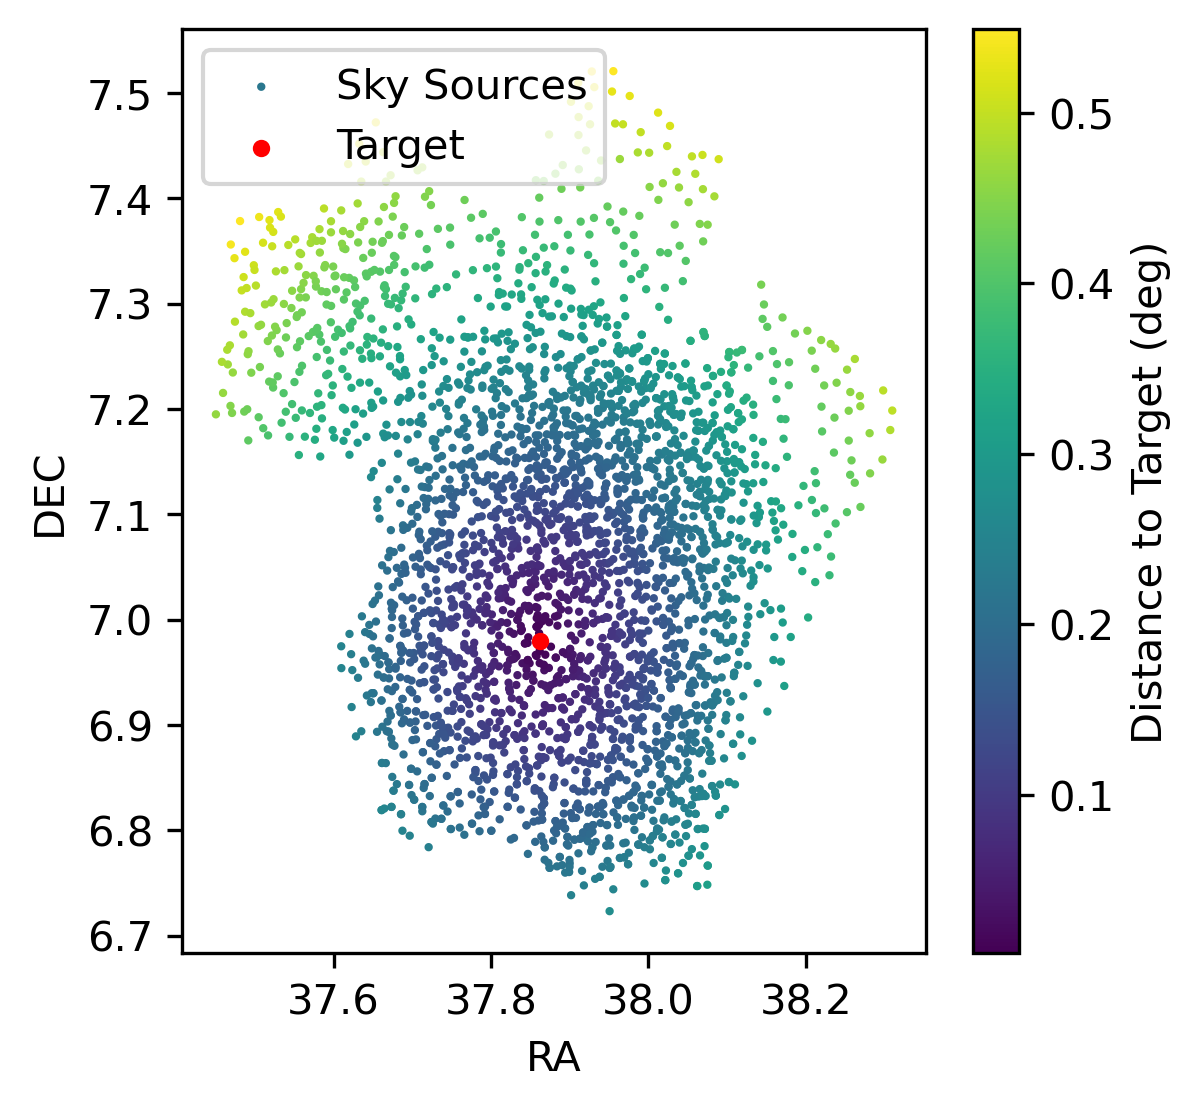

In [70]:
def plotPosition(resultList):
    """Plot the position of sky sources relative to the target.
    
    Parameters
    ----------
    resultList : `list`
        List of results dictionaries output by processVisit() for all visits
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
    allMeanImageFluxInAper = np.concatenate(
        [np.concatenate(res["meanImageFluxInAper"]) for res in resultList]
    )
    allMeanBackgroundInAper = np.concatenate(
        [np.concatenate(res["meanBackgroundInAper"]) for res in resultList]
    )
    allxSky = np.concatenate([np.concatenate(res["xSky"]) for res in resultList])
    allySky = np.concatenate([np.concatenate(res["ySky"]) for res in resultList])
    allraSky = np.concatenate([np.concatenate(res["raSky"]) for res in resultList])
    alldecSky = np.concatenate([np.concatenate(res["decSky"]) for res in resultList])
    allDist = np.concatenate([np.concatenate(res["distToTarget"]) for res in resultList])

    zeroMask = allMeanBackgroundInAper == 0
    allMeanImageFluxInAper = allMeanImageFluxInAper[~zeroMask]
    allMeanBackgroundInApe = allMeanBackgroundInAper[~zeroMask]

    allxSky = allxSky[~zeroMask]
    allySky = allySky[~zeroMask]
    allraSky = allraSky[~zeroMask]
    alldecSky = alldecSky[~zeroMask]
    allDist = allDist[~zeroMask]
    allSBRatio = np.concatenate([np.concatenate(res["SBRatio"]) for res in resultList])

    im = ax.scatter(allraSky, alldecSky, c=allDist, s=1, label="Sky Sources")
    ax.scatter(targetRa, targetDec, c="red", s=10, label="Target")
    ax.set_xlabel("RA")
    ax.set_ylabel("DEC")
    plt.colorbar(im, label="Distance to Target (deg)", ax=ax, orientation="vertical")
    ax.legend()

plotPosition(resultList)

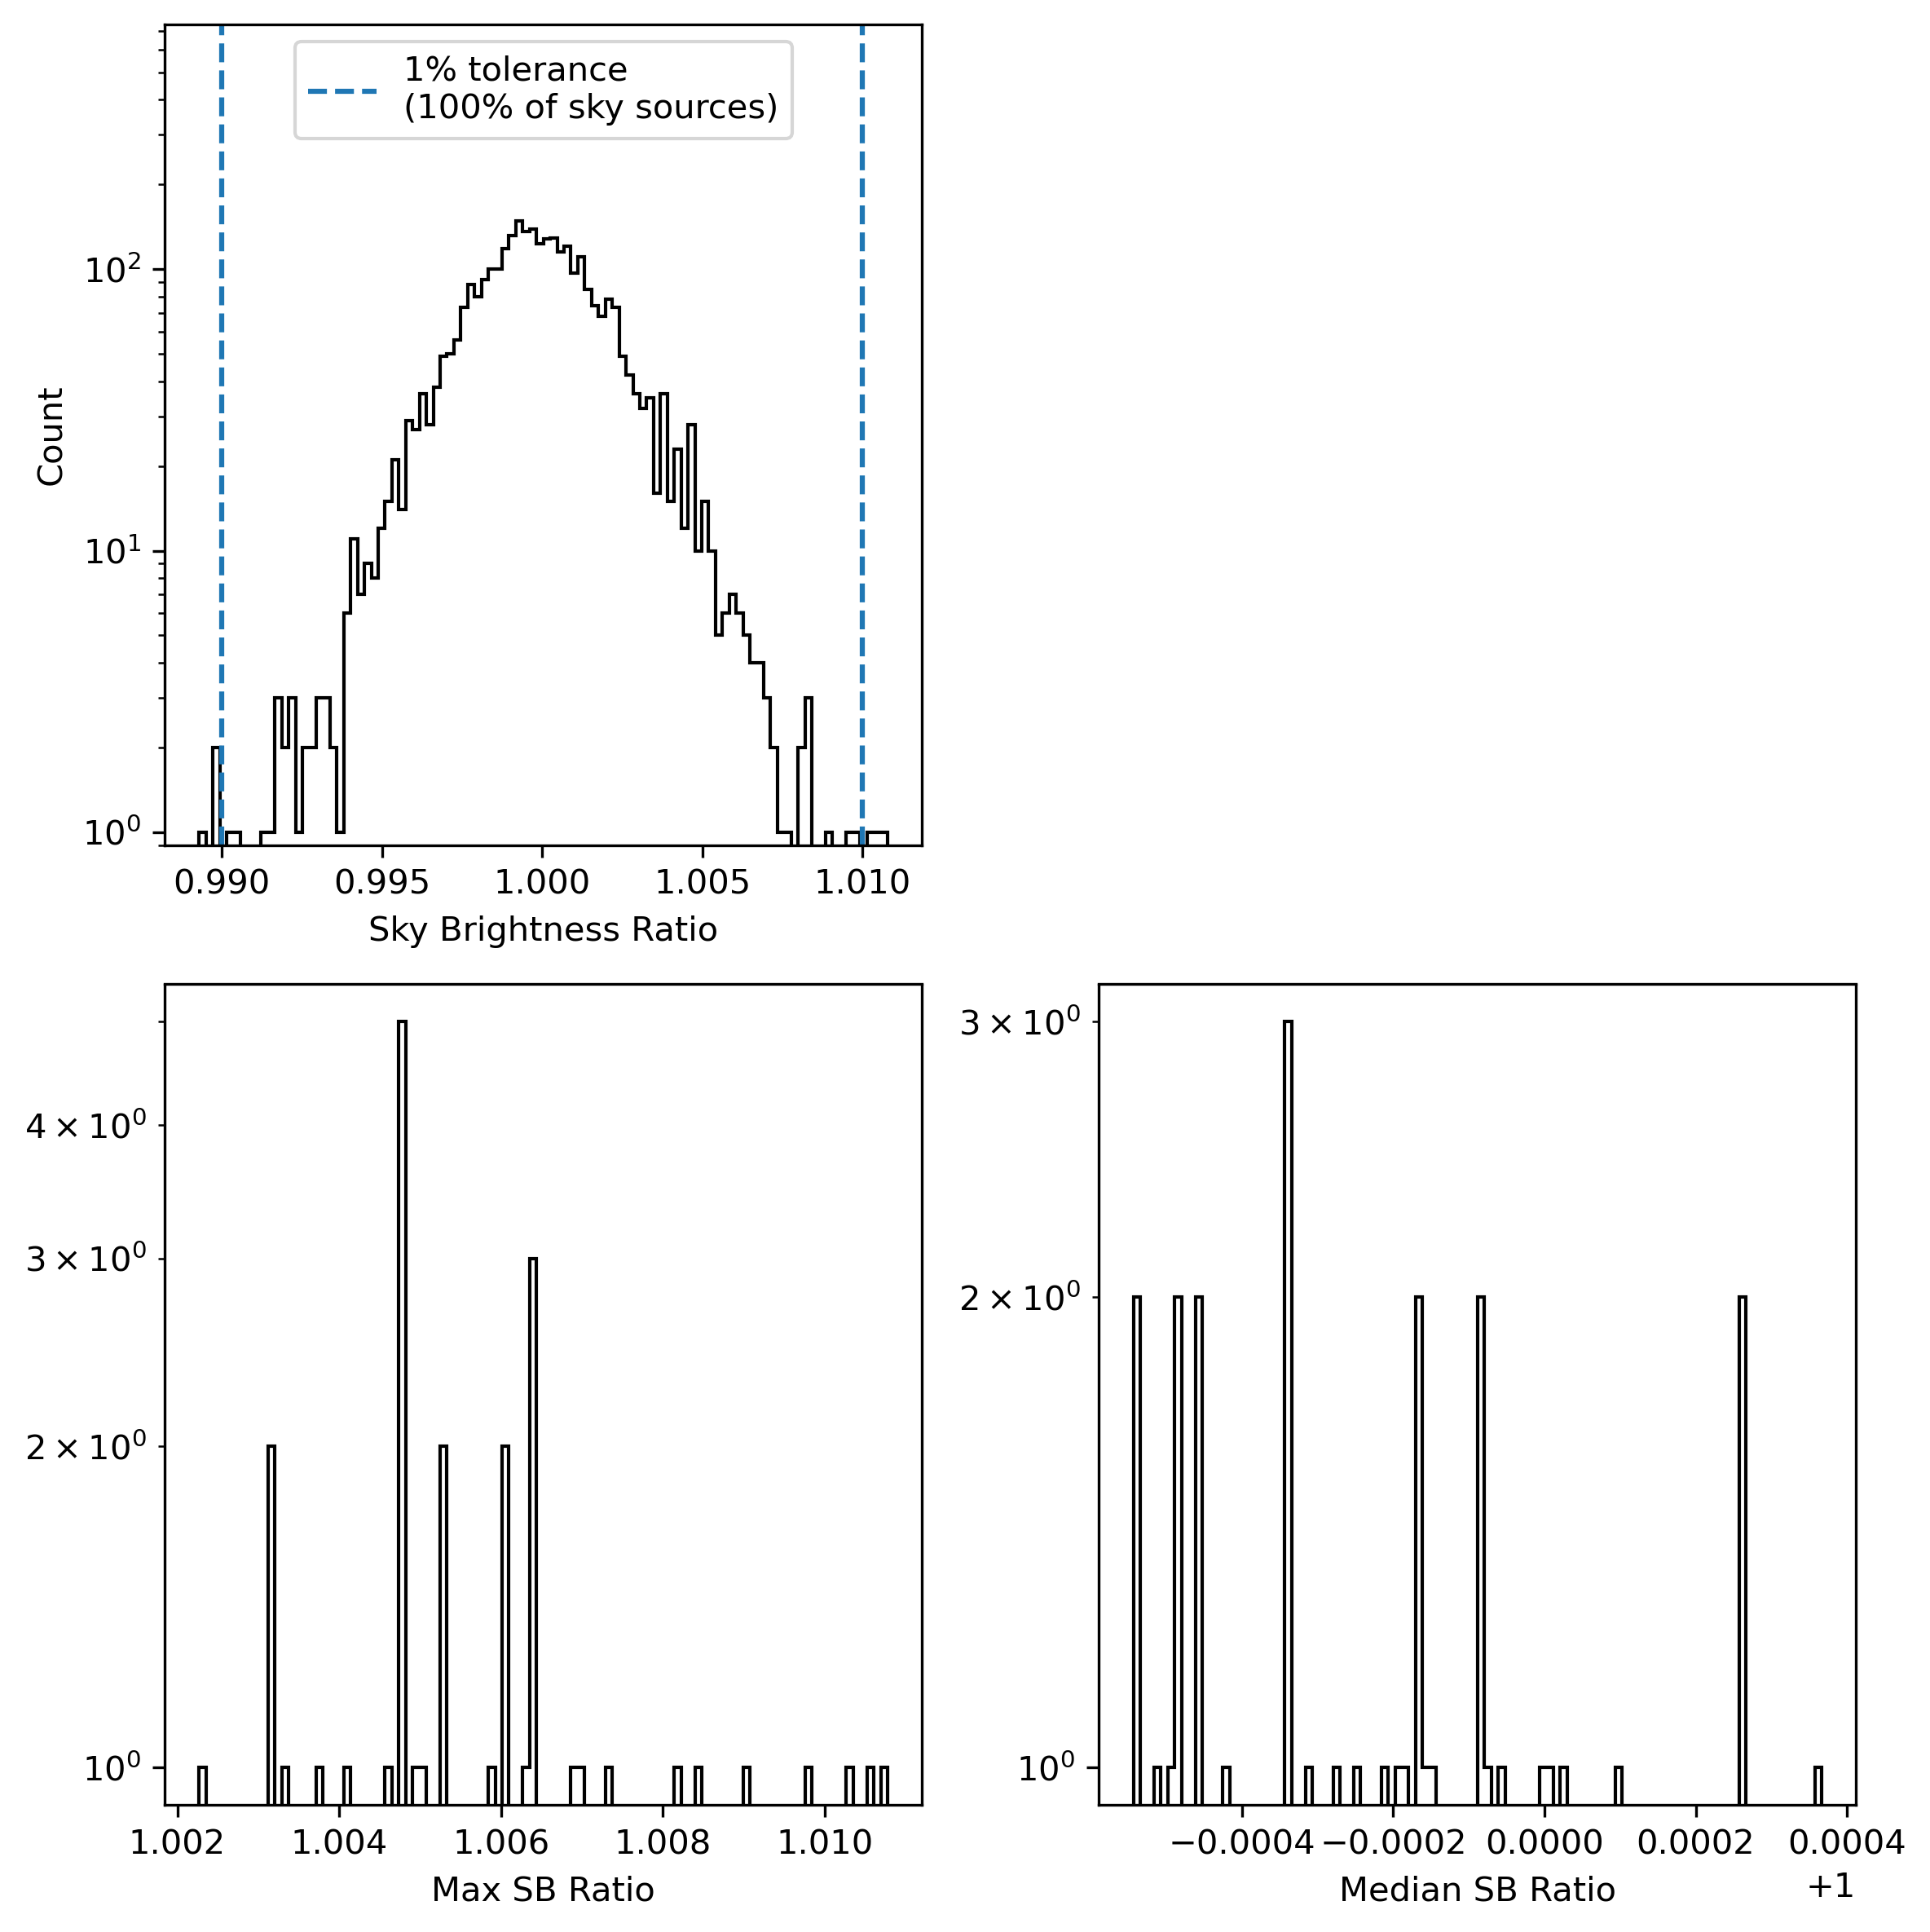

In [71]:
def plotSBRatio(resultList):
    """Plot the SBRatios visit.
    
    Parameters
    ----------
    resultList : `list`
        List of results dictionaries output by processVisit() for all visits
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
    axes = axes.flatten()
    allSBRatio = np.concatenate([np.concatenate(res["SBRatio"]) for res in resultList])
    frac_within_1pc = np.sum((allSBRatio >= 0.99) & (allSBRatio <= 1.01)) / len(allSBRatio)
    maxSBRatio = [np.max(innerRes) for res in resultList for innerRes in res["SBRatio"]]
    medianSBRatio = [np.median(innerRes) for res in resultList for innerRes in res["SBRatio"]]
    # maxSBRatio = [np.max(sbratio) for sbratio in SBRatio]
    # print(maxSBRatio)
    # medianSBRatio = np.max([np.median(res["SBRatio"]) for res in resultList])
    # maxSBRatio = np.array([np.max(res["SBRatio"][det]) for res in resultList for det in range(9)])
    # medianSBRatio = np.array([np.median(res["SBRatio"][det]) for res in resultList for det in range(9)])

    counts, bins, _ = axes[0].hist(allSBRatio, bins=100, histtype="step", color="k", log=True)
    axes[0].set_xlabel("Sky Brightness Ratio")
    axes[0].set_ylabel("Count")
    axes[0].axvline(1.01, linestyle="--")
    axes[0].axvline(0.99, linestyle="--", label=f"1% tolerance\n({frac_within_1pc*100:.0f}% of sky sources)")
    axes[0].legend()
    max_count = np.max(counts)
    axes[0].set_ylim(0.9, max_count * 5)

    axes[1].axis("off")

    axes[2].hist(maxSBRatio, bins=100, histtype="step", color="k", log=True)
    axes[2].set_xlabel("Max SB Ratio")

    axes[3].hist(medianSBRatio, bins=100, histtype="step", color="k", log=True)
    axes[3].set_xlabel("Median SB Ratio")

    plt.tight_layout()
    plt.show()


plotSBRatio(resultList)

Create scatterplots showing the `SBRatio` values as functions of the mean image fluxes within each sky aperture, the mean background fluxes within each sky aperture, and the x and y positions within each image.

In [72]:
np.array(res["annulusMeanBackground"])

array([ 771.5802002 ,    0.        ,    0.        ,    0.        ,
          0.        , 4225.94238281,  359.91793823, 1907.01831055,
          0.        , 1406.50134277,  759.24578857,    0.        ])

In [73]:
res = resultList[0]
np.array(res["meanBackgroundInAper"]) / np.array(res["annulusMeanBackground"])[:, np.newaxis] 

array([[0.995342  , 0.99193084, 0.99648917, ..., 0.99879432, 0.        ,
        0.99029872],
       [0.98364855, 1.00563326, 0.9856427 , ..., 0.9899632 , 1.00675337,
        0.99282343],
       [0.99019324, 0.99266692, 0.99499926, ..., 0.99924955, 0.99046851,
        0.99447216],
       ...,
       [0.99461831, 0.9925982 , 0.99301149, ..., 0.99417477, 0.99408706,
        0.99370991],
       [0.9917365 , 0.99753888, 0.99243435, ..., 0.99409652, 0.99470291,
        0.99844754],
       [0.99255313, 0.99692061, 0.99119259, ..., 0.9969093 , 0.99350927,
        0.99606961]])

High SB Ratio: 0.0
[1.00000761 1.00000341 1.00000274 1.00000434 1.00000227 1.00000368
 1.00000301 1.00000305 1.00000265 1.00000334 1.00000263 1.00000219
 1.00000119 1.00000058 1.00000019 1.00000001 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


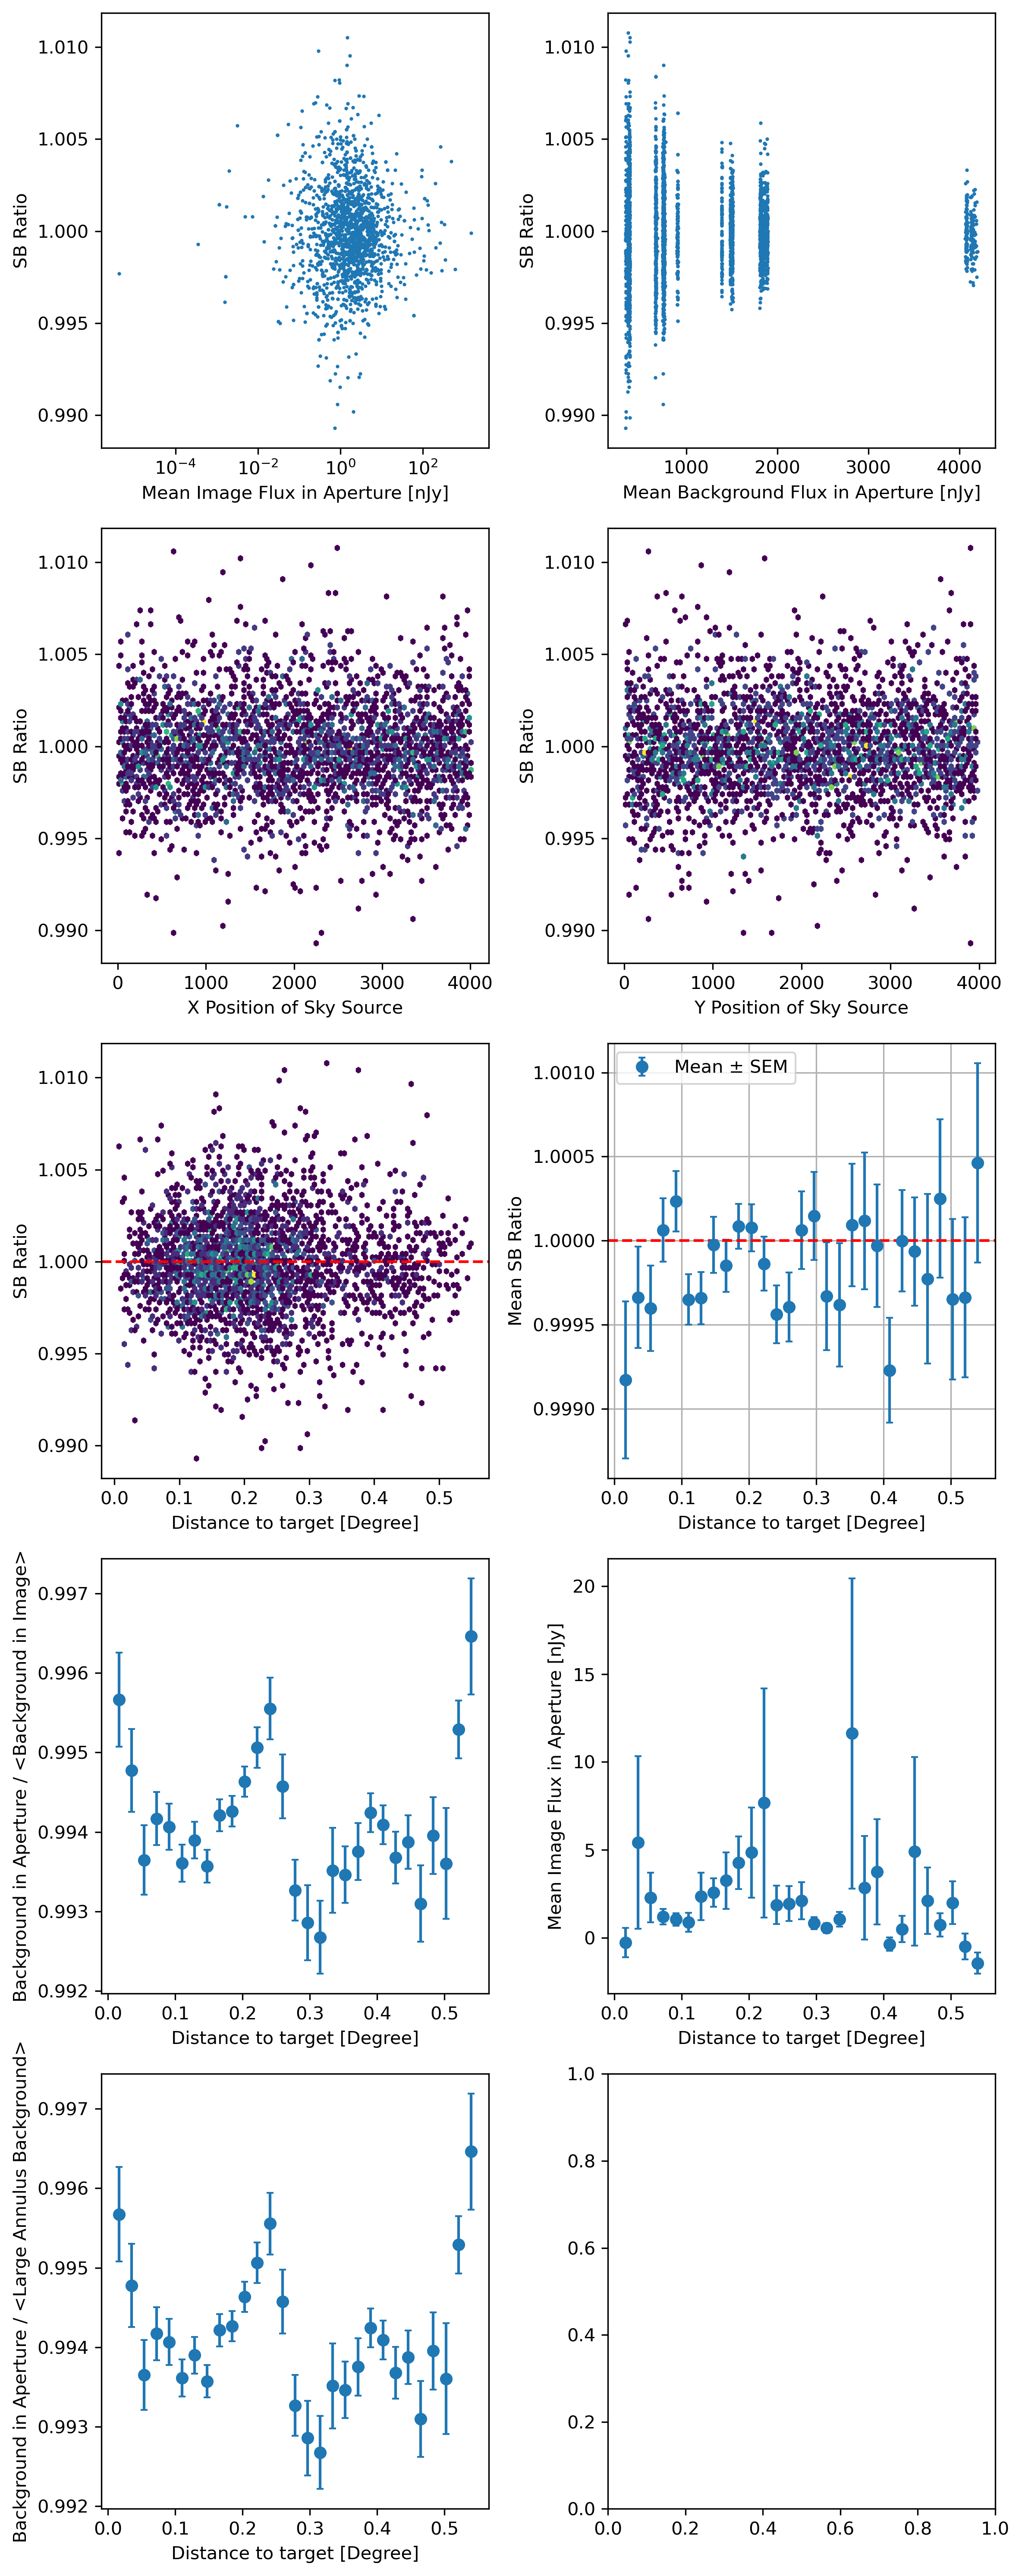

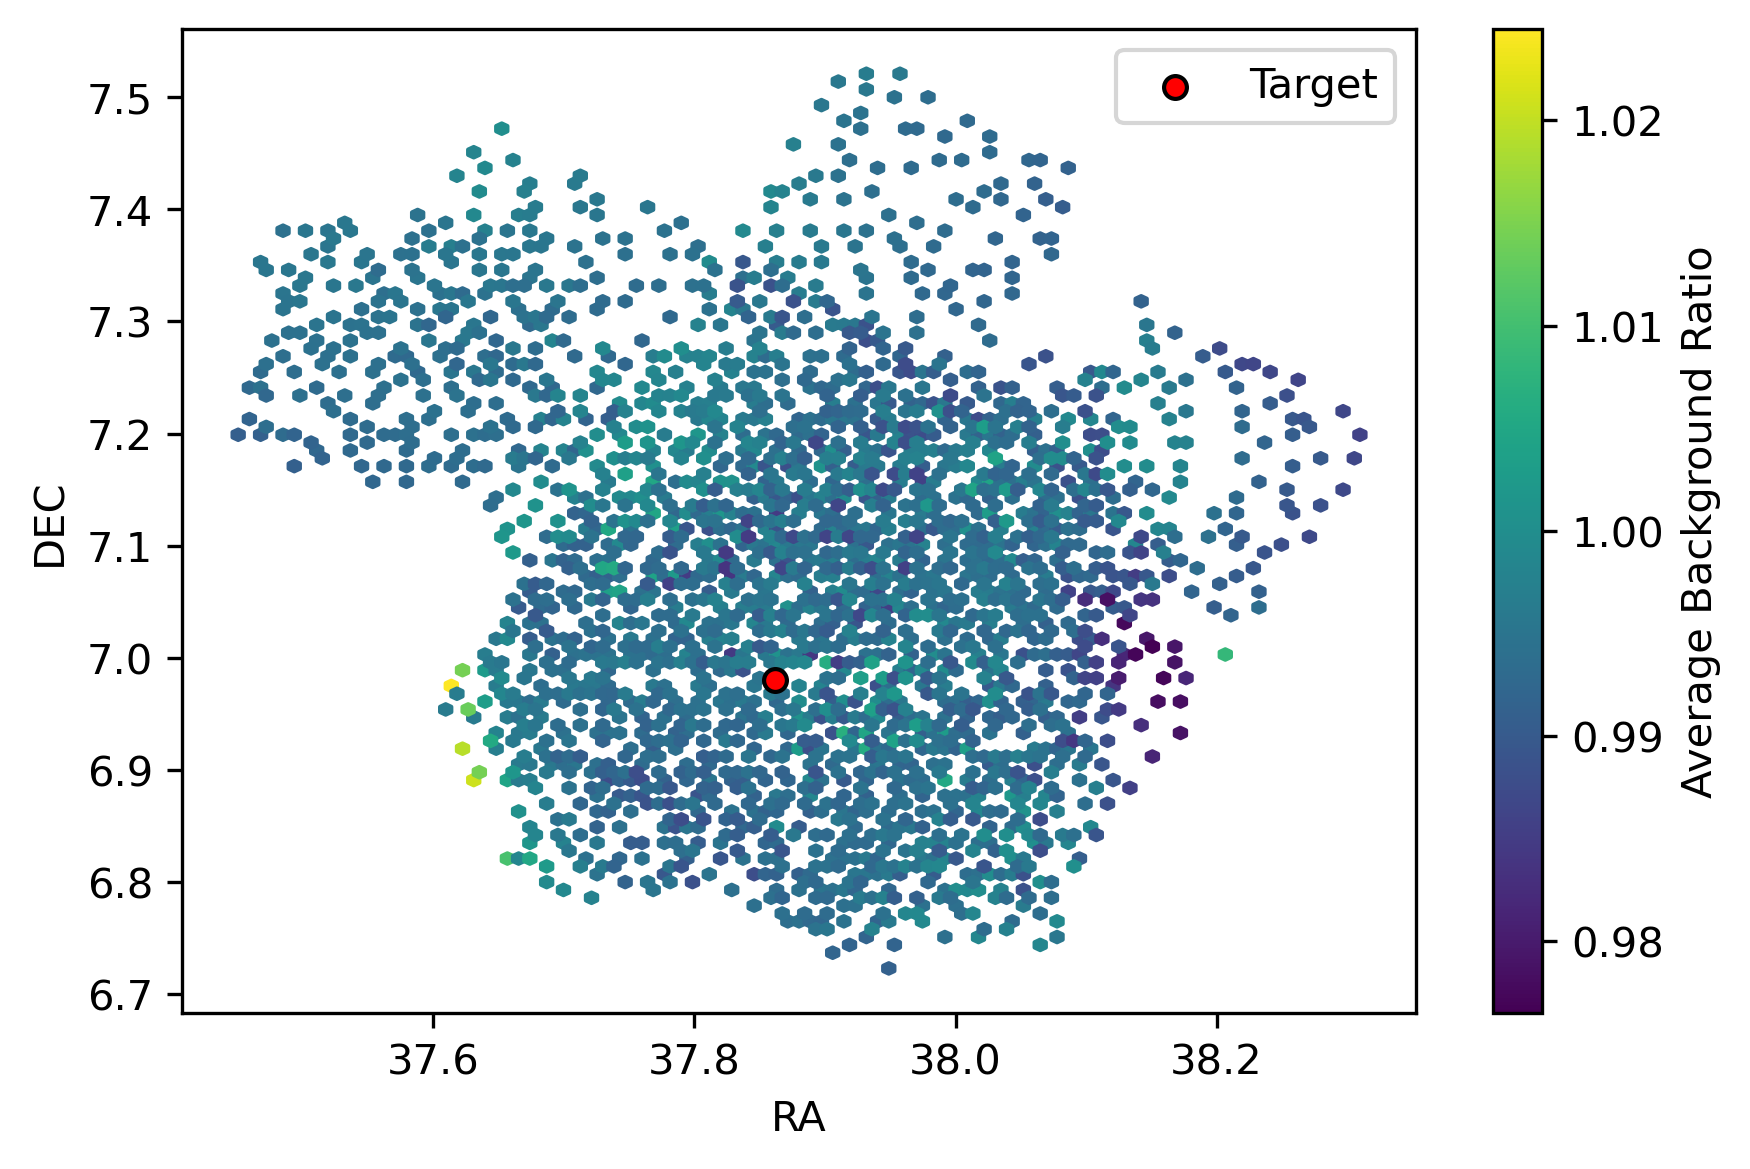

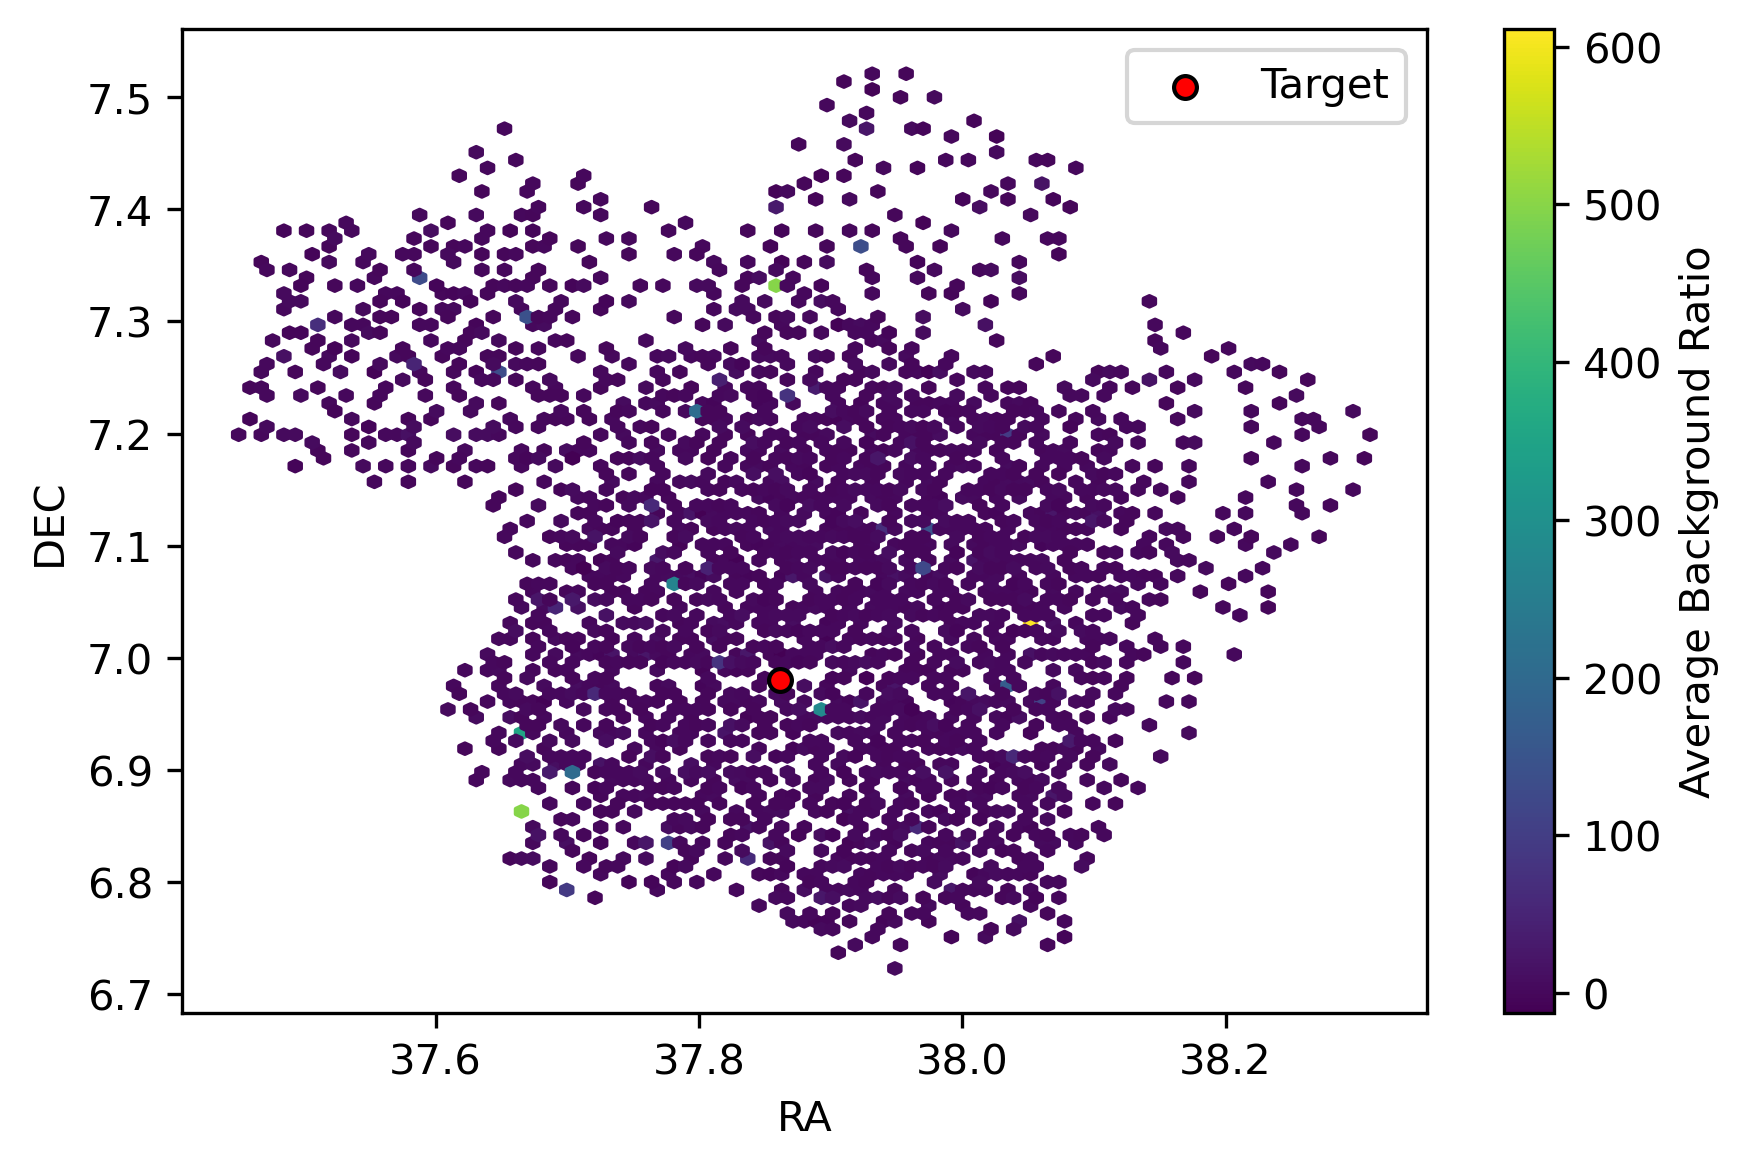

In [79]:
def plotCorrelation(resultList):
    """Plot the correlation between the image flux and SB ratio

    Parameters
    ----------
    resultList : `list`
        List of results dictionaries output by processVisit() for all visits
    """
    fig, axes = plt.subplots(5, 2, figsize=(8, 20), dpi=300)
    allMeanImageFluxInApe = np.concatenate(
        [np.concatenate(res["meanImageFluxInAper"]) for res in resultList]
    )
    allMeanBackgroundInApe = np.concatenate(
        [np.concatenate(res["meanBackgroundInAper"]) for res in resultList]
    )
    allMeanBackgroundRatio = np.concatenate(
        [np.concatenate(np.array(res["meanBackgroundInAper"]) / np.array(res["meanBackgroundInImage"])[:, np.newaxis]) for res in resultList]
    )
    
    allLargeBackgroundRatio = np.concatenate(
        [np.concatenate(np.array(res["meanBackgroundInAper"]) / np.array(res["annulusMeanBackground"])[:, np.newaxis]) for res in resultList]
    )
    # take out all inf values
    allMeanBackgroundRatio = allMeanBackgroundRatio[np.isfinite(allMeanBackgroundRatio)]

    allxSky = np.concatenate([np.concatenate(res["xSky"]) for res in resultList])
    allySky = np.concatenate([np.concatenate(res["ySky"]) for res in resultList])
    allraSky = np.concatenate([np.concatenate(res["raSky"]) for res in resultList])
    alldecSky = np.concatenate([np.concatenate(res["decSky"]) for res in resultList])
    allDist = np.concatenate([np.concatenate(res["distToTarget"]) for res in resultList])

    zeroMask = allMeanBackgroundInApe == 0
    allMeanImageFluxInAper = allMeanImageFluxInApe[~zeroMask]
    allMeanBackgroundInApe = allMeanBackgroundInApe[~zeroMask]
    allMeanBackgroundRatio = allMeanBackgroundRatio[~zeroMask]
    allLargeBackgroundRatio = allLargeBackgroundRatio[~zeroMask]

    allxSky = allxSky[~zeroMask]
    allySky = allySky[~zeroMask]
    allraSky = allraSky[~zeroMask]
    alldecSky = alldecSky[~zeroMask]
    allDist = allDist[~zeroMask]
    allSBRatio = np.concatenate([np.concatenate(res["SBRatio"]) for res in resultList])

    assert len(allMeanImageFluxInAper) == len(
        allSBRatio
    ), f"Length mismatch: {len(allMeanImageFluxInAper)} vs {len(allSBRatio)}"

    axes[0][0].scatter(allMeanImageFluxInAper, allSBRatio, s=1)
    axes[0][0].set_xlabel("Mean Image Flux in Aperture [nJy]")
    axes[0][0].set_ylabel("SB Ratio")
    axes[0][0].set_xscale("log")

    axes[0][1].scatter(allMeanBackgroundInApe, allSBRatio, s=1)
    axes[0][1].set_xlabel("Mean Background Flux in Aperture [nJy]")
    axes[0][1].set_ylabel("SB Ratio")

    axes[1][0].hexbin(allxSky, allSBRatio, mincnt=1)
    axes[1][0].set_xlabel("X Position of Sky Source")
    axes[1][0].set_ylabel("SB Ratio")
    axes[1][1].hexbin(allySky, allSBRatio, mincnt=1)
    axes[1][1].set_xlabel("Y Position of Sky Source")
    axes[1][1].set_ylabel("SB Ratio")

    axes[2][0].hexbin(allDist, allSBRatio, mincnt=1)
    axes[2][0].set_xlabel("Distance to target [Degree]")
    axes[2][0].set_ylabel("SB Ratio")
    axes[2][0].axhline(1, color="r", linestyle="--")

    highSBRatio = allSBRatio > 1.5
    print(f"High SB Ratio: {np.sum(highSBRatio)/len(allSBRatio)}")

    from scipy.stats import sem
    
    # Bin the distances
    distBins = np.linspace(np.min(allDist), np.max(allDist), 30)
    binCenters = 0.5 * (distBins[:-1] + distBins[1:])
    digitized = np.digitize(allDist, distBins)
    
    meanSbByDist = []
    meanBackgroundRatioByDist = []
    meanFluxByDist = []
    meanLargeBackgroundRatioByDist = []
    semSbByDist = []
    semBackgroundRatioByDist = []
    semFluxByDist = []
    semLargeBackgroundRatioByDist = []
    
    
    for i in range(1, len(distBins)):
        SBvaluesInBin = allSBRatio[digitized == i]
        backgroundRatioValuesInBin = allMeanBackgroundRatio[digitized == i]
        fluxInBin = allMeanImageFluxInAper[digitized == i]
        largeBackgroundRatioValuesInBin = allLargeBackgroundRatio[digitized == i]
        
        if len(SBvaluesInBin) > 0:
            meanSbByDist.append(np.mean(SBvaluesInBin))
            semSbByDist.append(sem(SBvaluesInBin))

        else:
            meanSbByDist.append(np.nan)
            semSbByDist.append(np.nan)
            meanFluxByDist.append(np.nan)

        if len(backgroundRatioValuesInBin) > 0:
            meanBackgroundRatioByDist.append(np.mean(backgroundRatioValuesInBin))
            semBackgroundRatioByDist.append(sem(backgroundRatioValuesInBin))
        
        if len(fluxInBin) > 0:
            meanFluxByDist.append(np.mean(fluxInBin))
            semFluxByDist.append(sem(fluxInBin))
        
        if len(largeBackgroundRatioValuesInBin) > 0:
            meanLargeBackgroundRatioByDist.append(np.mean(largeBackgroundRatioValuesInBin))
            semLargeBackgroundRatioByDist.append(sem(largeBackgroundRatioValuesInBin))
    
    axes[2][1].errorbar(
        binCenters, meanSbByDist, yerr=semSbByDist,
        fmt='o', capsize=2, label="Mean ± SEM"
    )
    axes[2][1].set_xlabel("Distance to target [Degree]")
    axes[2][1].set_ylabel("Mean SB Ratio")
    axes[2][1].axhline(1, color="r", linestyle="--")
    axes[2][1].grid(True)
    axes[2][1].legend()

    axes[3][0].errorbar(
        binCenters, meanBackgroundRatioByDist, yerr=semBackgroundRatioByDist,
        fmt='o', capsize=2, label="Mean ± SEM"
    )
    axes[3][0].set_xlabel("Distance to target [Degree]")
    axes[3][0].set_ylabel("Background in Aperture / <Background in Image>")

    axes[3][1].errorbar(
        binCenters, meanFluxByDist, yerr=semFluxByDist,
        fmt='o', capsize=2, label="Mean ± SEM"
    )
    axes[3][1].set_xlabel("Distance to target [Degree]")
    axes[3][1].set_ylabel("Mean Image Flux in Aperture [nJy]")
    
    axes[4][0].errorbar(
        binCenters, meanLargeBackgroundRatioByDist, yerr=semLargeBackgroundRatioByDist,
        fmt='o', capsize=2, label="Mean ± SEM"
    )
    axes[4][0].set_xlabel("Distance to target [Degree]")
    axes[4][0].set_ylabel("Background in Aperture / <Large Annulus Background>")

    print(np.array(meanLargeBackgroundRatioByDist) / np.array(meanBackgroundRatioByDist))

    # axes[3][0].errorbar(
    #     binCenters, meanBackgroundByDist, yerr=semBackgroundByDist,
    #     fmt='o', capsize=2
    # )

    # axes[3][1].scatter(allraSky, alldecSky, c=allMeanBackgroundInApe)

    
    plt.tight_layout()
    plt.show()
    
    # fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
    # im = ax.scatter(allraSky, alldecSky, c=allMeanBackgroundRatio, s=1, alpha=0.5)
    # ax.set_xlabel("RA")
    # ax.set_ylabel("DEC")
    # plt.scatter(targetRa, targetDec, c="red", s=10, label="Target")
    # plt.colorbar(im, label="Background Ratio", ax=ax, orientation="vertical")

    # plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

    hb = ax.hexbin(
        allraSky,
        alldecSky,
        C=allMeanBackgroundRatio,
        reduce_C_function=np.mean,
        gridsize=100,  # Adjust for resolution
        cmap='viridis',  # Optional colormap
        mincnt=1,  # Only show bins with at least 1 point
    )

    ax.set_xlabel("RA")
    ax.set_ylabel("DEC")

    # Plot target position
    ax.scatter(targetRa, targetDec, c="red", s=30, label="Target", edgecolors='black')

    # Add colorbar
    plt.colorbar(hb, label="Average Background Ratio", ax=ax, orientation="vertical")

    # Optional: add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

    hb = ax.hexbin(
        allraSky,
        alldecSky,
        C=allMeanImageFluxInAper,
        reduce_C_function=np.mean,
        gridsize=100,  # Adjust for resolution
        cmap='viridis',  # Optional colormap
        mincnt=1,  # Only show bins with at least 1 point
    )

    ax.set_xlabel("RA")
    ax.set_ylabel("DEC")

    # Plot target position
    ax.scatter(targetRa, targetDec, c="red", s=30, label="Target", edgecolors='black')

    # Add colorbar
    plt.colorbar(hb, label="Average Background Ratio", ax=ax, orientation="vertical")

    # Optional: add legend
    ax.legend()

    plt.tight_layout()
    plt.show()
    

plotCorrelation(resultList)


# rerun science pipeline and lower the chebyshev order background 
# see if the ratio is still low


In [75]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plotPatchBoundaries(ax, tpDict, skymap):
    """Plot the boundaries of each patch with different colors and add legend + labels.

    Parameters
    ----------
    ax : `matplotlib.axes.Axes`
        Matplotlib axis to draw the patch boundaries on.
    tpDict : `dict`
        Dictionary of tract IDs and associated patch IDs.
    skymap : `lsst.skymap.SkyMap`
        The sky map object to get the patch information from.
    """
    # Use a colormap with enough distinct colors
    cmap = plt.get_cmap('tab20')  # Up to 20 discrete colors
    colorList = cmap.colors
    colorCycle = len(colorList)

    # Prepare legend handles
    legend_handles = []

    # Loop over tracts and patches
    for idx, (tract, patches) in enumerate(tpDict.items()):
        tractInfo = skymap[tract]
        for patchIndex in patches:
            patchInfo = tractInfo.getPatchInfo(patchIndex)
            patchBBox = patchInfo.getOuterBBox()

            corners = [geom.Point2D(patchBBox.getMinX(), patchBBox.getMinY()),
                       geom.Point2D(patchBBox.getMinX(), patchBBox.getMaxY()),
                       geom.Point2D(patchBBox.getMaxX(), patchBBox.getMaxY()),
                       geom.Point2D(patchBBox.getMaxX(), patchBBox.getMinY())]

            # Convert to sky coordinates
            skyCorners = [tractInfo.getWcs().pixelToSky(p) for p in corners]
            ra = [c.getLongitude().asDegrees() for c in skyCorners]
            dec = [c.getLatitude().asDegrees() for c in skyCorners]

            # Close the polygon
            ra.append(ra[0])
            dec.append(dec[0])

            # Assign a color
            color = colorList[(idx + patchIndex) % colorCycle]

            # Plot the patch boundary
            ax.plot(ra, dec, color=color, linewidth=1, alpha=0.8)

            # Label the center of the patch
            # Label the center of the patch
            bbox = patchInfo.getOuterBBox()
            patchCenterPix = geom.Point2D(
                0.5 * (bbox.getMinX() + bbox.getMaxX()),
                0.5 * (bbox.getMinY() + bbox.getMaxY())
            )
            patchCenterSky = tractInfo.getWcs().pixelToSky(patchCenterPix)
            centerRa = patchCenterSky.getLongitude().asDegrees()
            centerDec = patchCenterSky.getLatitude().asDegrees()

            ax.text(centerRa, centerDec, f"{tract}-{patchIndex}", fontsize=6, color=color,
                    ha='center', va='center', alpha=0.9)


            # For legend, add once per patch
            legend_label = f"Tract {tract} Patch {patchIndex}"
            legend_handles.append(mpatches.Patch(color=color, label=legend_label))

    # Add legend outside of plot
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, frameon=False)

    ax.scatter(targetRa, targetDec, c="red", s=30, label="Target", edgecolors='black')

    # Labels
    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("Dec [deg]")
    ax.set_title("Patch Boundaries with Labels and Colors")

    # Optional: invert x-axis for astronomical convention
    ax.invert_xaxis()



In [63]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from shapely.geometry import MultiPoint
from tqdm import tqdm

def plotPatchAndVisitBoundaries(ax, tpDict, skymap, visits, detectors, butler, collection, instrument):
    """Plot the boundaries of each patch and visits, with different colors and add legend + labels.

    Parameters
    ----------
    ax : `matplotlib.axes.Axes`
        Matplotlib axis to draw the boundaries on.
    tpDict : `dict`
        Dictionary of tract IDs and associated patch IDs.
    skymap : `lsst.skymap.SkyMap`
        The sky map object to get the patch information from.
    visits : `list`
        List of visit IDs.
    detectors : `list`
        List of detector IDs.
    butler : `Butler`
        Butler instance to query datasets.
    collection : `str`
        Collection name.
    instrument : `str`
        Instrument name ("LSSTComCam" or "HSC")
    """
    # Patch boundaries first
    cmap = plt.get_cmap('tab20')
    colorList = cmap.colors
    colorCycle = len(colorList)

    legend_handles = []

    for idx, (tract, patches) in enumerate(tpDict.items()):
        tractInfo = skymap[tract]
        for patchIndex in patches:
            patchInfo = tractInfo.getPatchInfo(patchIndex)
            patchBBox = patchInfo.getOuterBBox()

            corners = [geom.Point2D(patchBBox.getMinX(), patchBBox.getMinY()),
                       geom.Point2D(patchBBox.getMinX(), patchBBox.getMaxY()),
                       geom.Point2D(patchBBox.getMaxX(), patchBBox.getMaxY()),
                       geom.Point2D(patchBBox.getMaxX(), patchBBox.getMinY())]

            skyCorners = [tractInfo.getWcs().pixelToSky(p) for p in corners]
            ra = [c.getLongitude().asDegrees() for c in skyCorners]
            dec = [c.getLatitude().asDegrees() for c in skyCorners]

            ra.append(ra[0])
            dec.append(dec[0])

            color = colorList[(idx + patchIndex) % colorCycle]

            ax.plot(ra, dec, color=color, linewidth=1, alpha=0.8)

            # Label patch center
            bbox = patchInfo.getOuterBBox()
            patchCenterPix = geom.Point2D(
                0.5 * (bbox.getMinX() + bbox.getMaxX()),
                0.5 * (bbox.getMinY() + bbox.getMaxY())
            )
            patchCenterSky = tractInfo.getWcs().pixelToSky(patchCenterPix)
            centerRa = patchCenterSky.getLongitude().asDegrees()
            centerDec = patchCenterSky.getLatitude().asDegrees()

            ax.text(centerRa, centerDec, f"{tract}-{patchIndex}", fontsize=6, color=color,
                    ha='center', va='center', alpha=0.9)

            legend_label = f"Tract {tract} Patch {patchIndex}"
            legend_handles.append(mpatches.Patch(color=color, label=legend_label))

    # Visit boundaries
    visit_cmap = plt.get_cmap('tab20b')
    visit_colors = visit_cmap.colors
    visit_color_cycle = len(visit_colors)

    for idx, visit in enumerate(tqdm(visits, desc="Plotting visit boundaries")):
        visit_points = []

        for detector in detectors:
            dataId = {'instrument': instrument, 'visit': visit, 'detector': detector, 'band': 'g'}
            try:
                calexp = butler.get('calexp', dataId=dataId, collections=collection)
            except Exception as e:
                # Optional: keep quiet to avoid clutter
                continue

            bbox = calexp.getBBox()
            wcs = calexp.getWcs()

            corners = [geom.Point2D(bbox.getMinX(), bbox.getMinY()),
                       geom.Point2D(bbox.getMinX(), bbox.getMaxY()),
                       geom.Point2D(bbox.getMaxX(), bbox.getMaxY()),
                       geom.Point2D(bbox.getMaxX(), bbox.getMinY())]

            skyCorners = [wcs.pixelToSky(p) for p in corners]
            points = [(c.getLongitude().asDegrees(), c.getLatitude().asDegrees()) for c in skyCorners]
            visit_points.extend(points)

        # Draw visit boundary if we have points
        if visit_points:
            polygon = MultiPoint(visit_points).convex_hull
            x, y = polygon.exterior.xy
            color = visit_colors[idx % visit_color_cycle]
            ax.plot(x, y, color=color, linestyle='--', alpha=0.5, linewidth=1)

    # Target marker
    ax.scatter(targetRa, targetDec, c="red", s=30, label="Target", edgecolors='black')

    # Legend
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, frameon=False)

    # Labels
    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("Dec [deg]")
    ax.set_title("Patch and Visit Boundaries with Labels and Colors")

    # Astronomical convention
    ax.invert_xaxis()


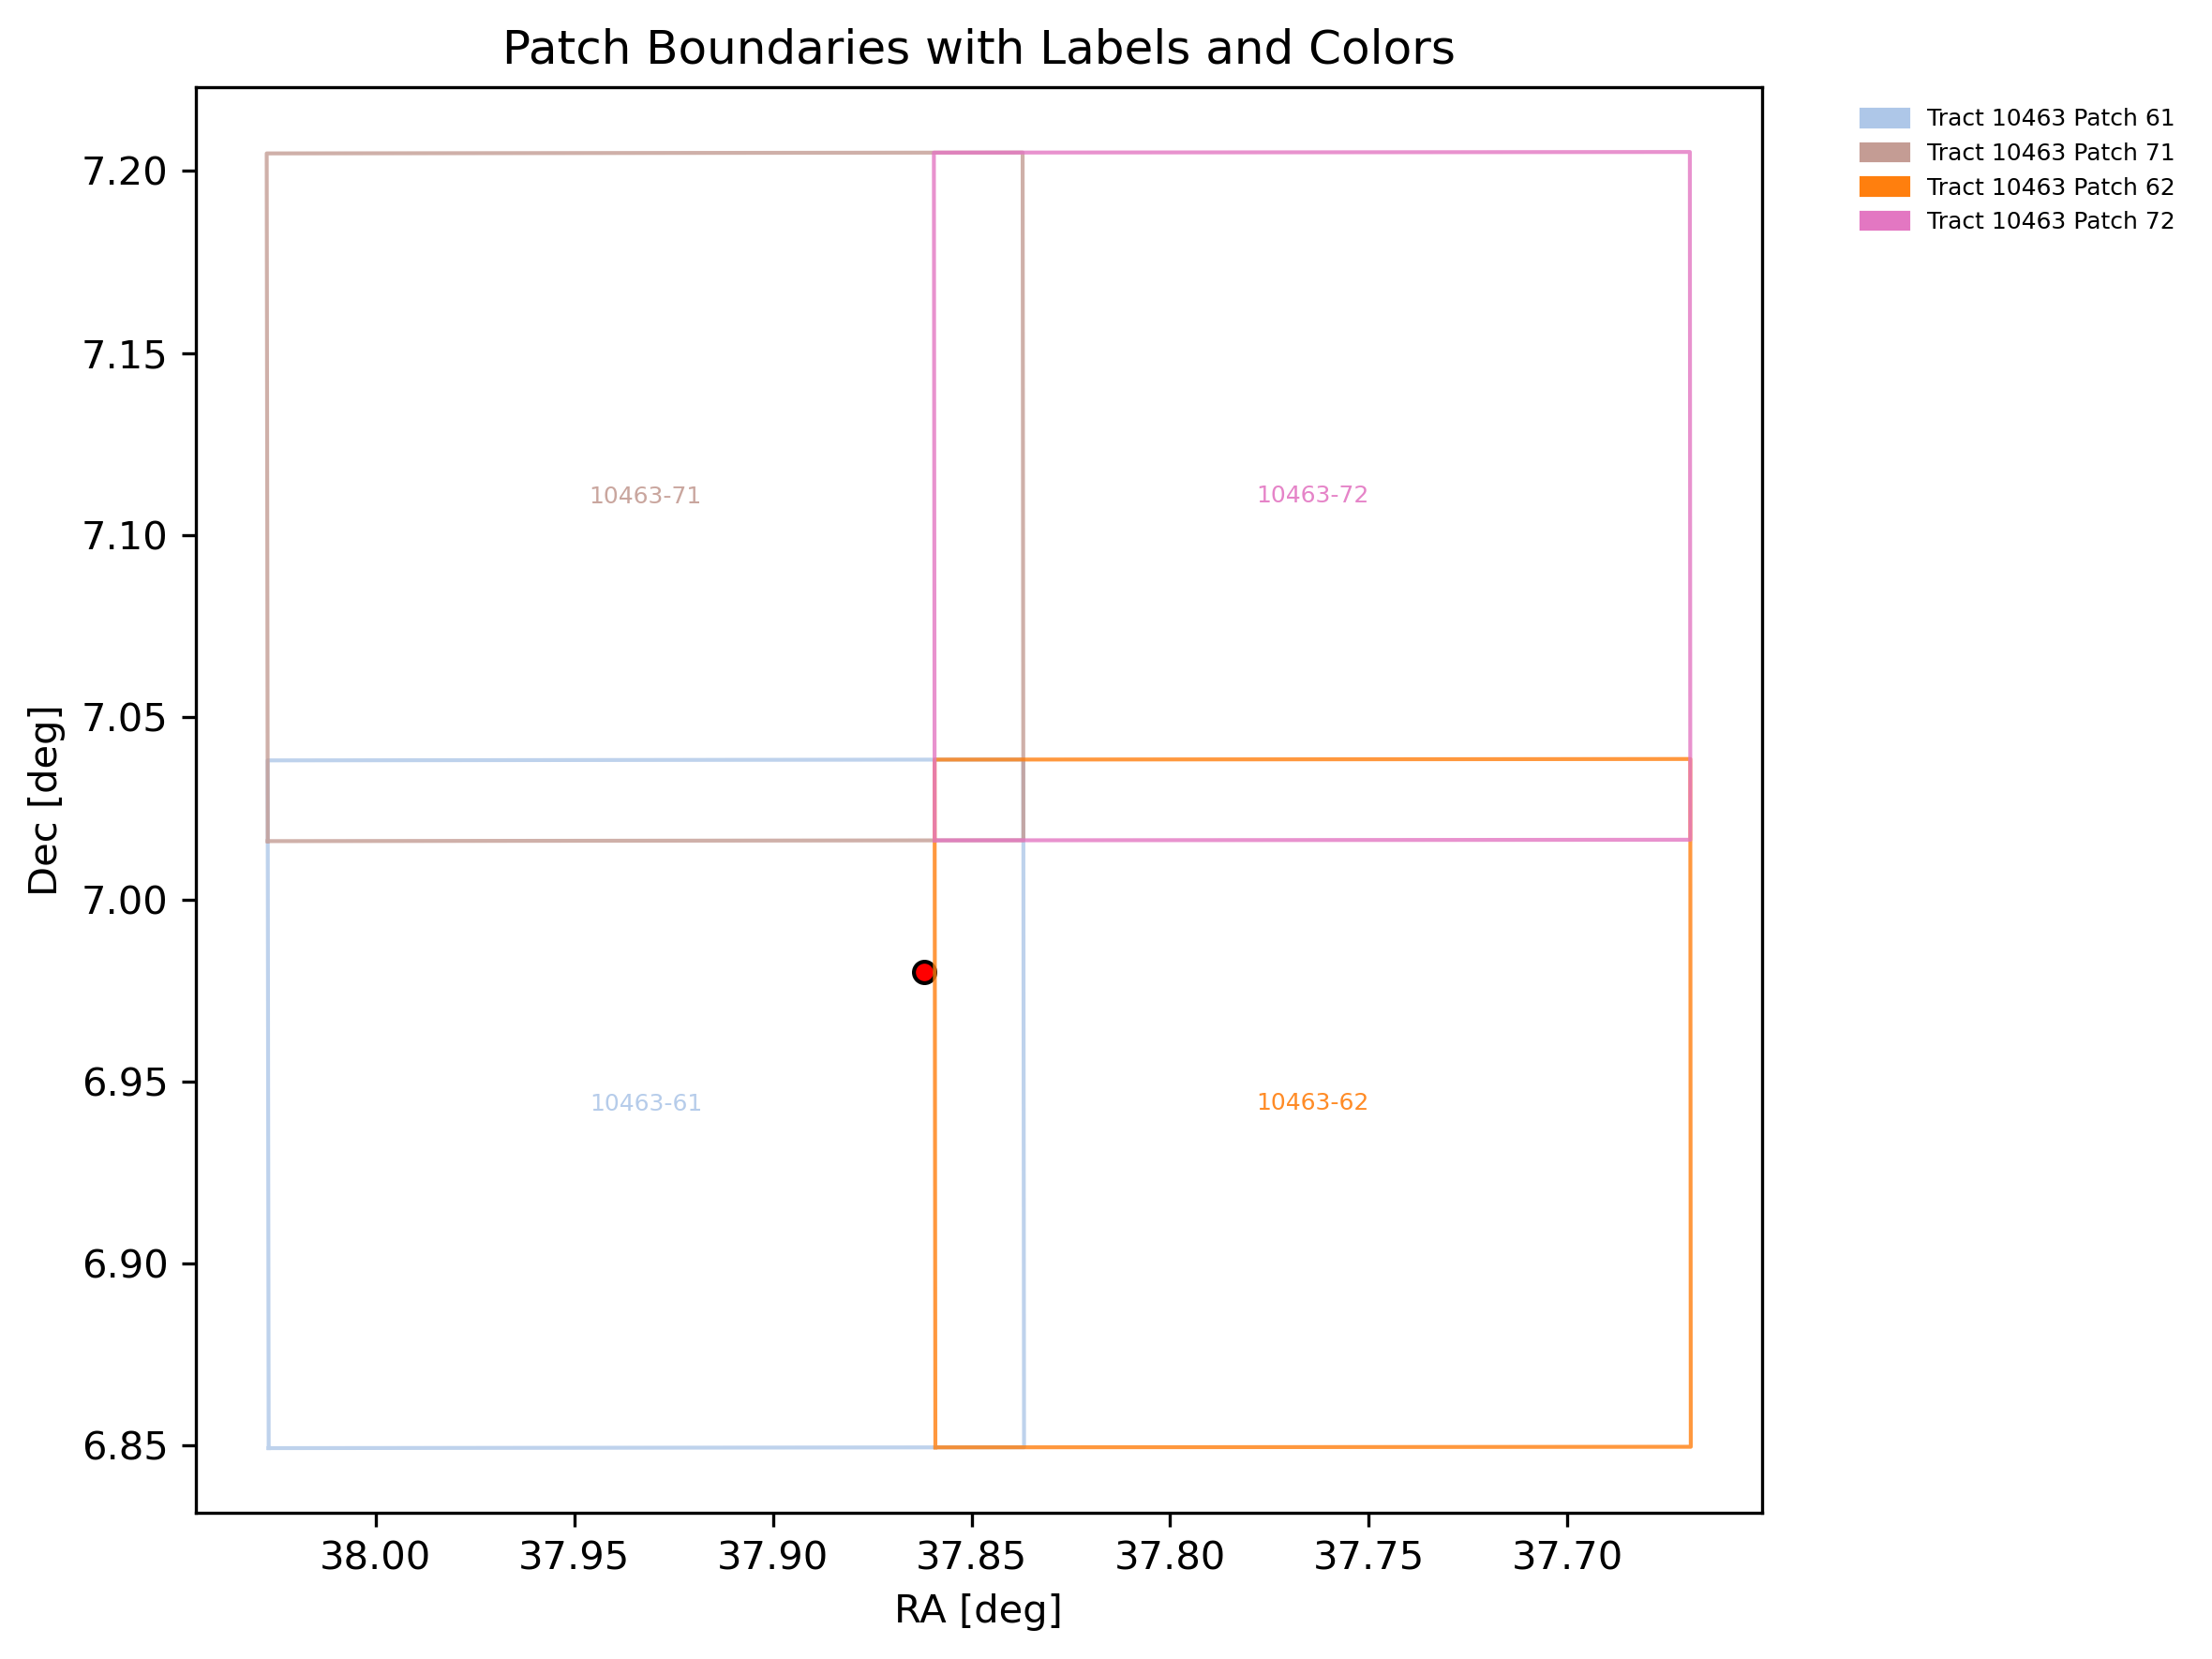

In [77]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(8, 6))
plotPatchBoundaries(ax, tpDict, skymap)
plt.tight_layout()
plt.show()


Found 175 visits overlapping with patches in tpDict


Plotting visit boundaries: 100%|███████████████████| 175/175 [21:57<00:00,  7.53s/it]


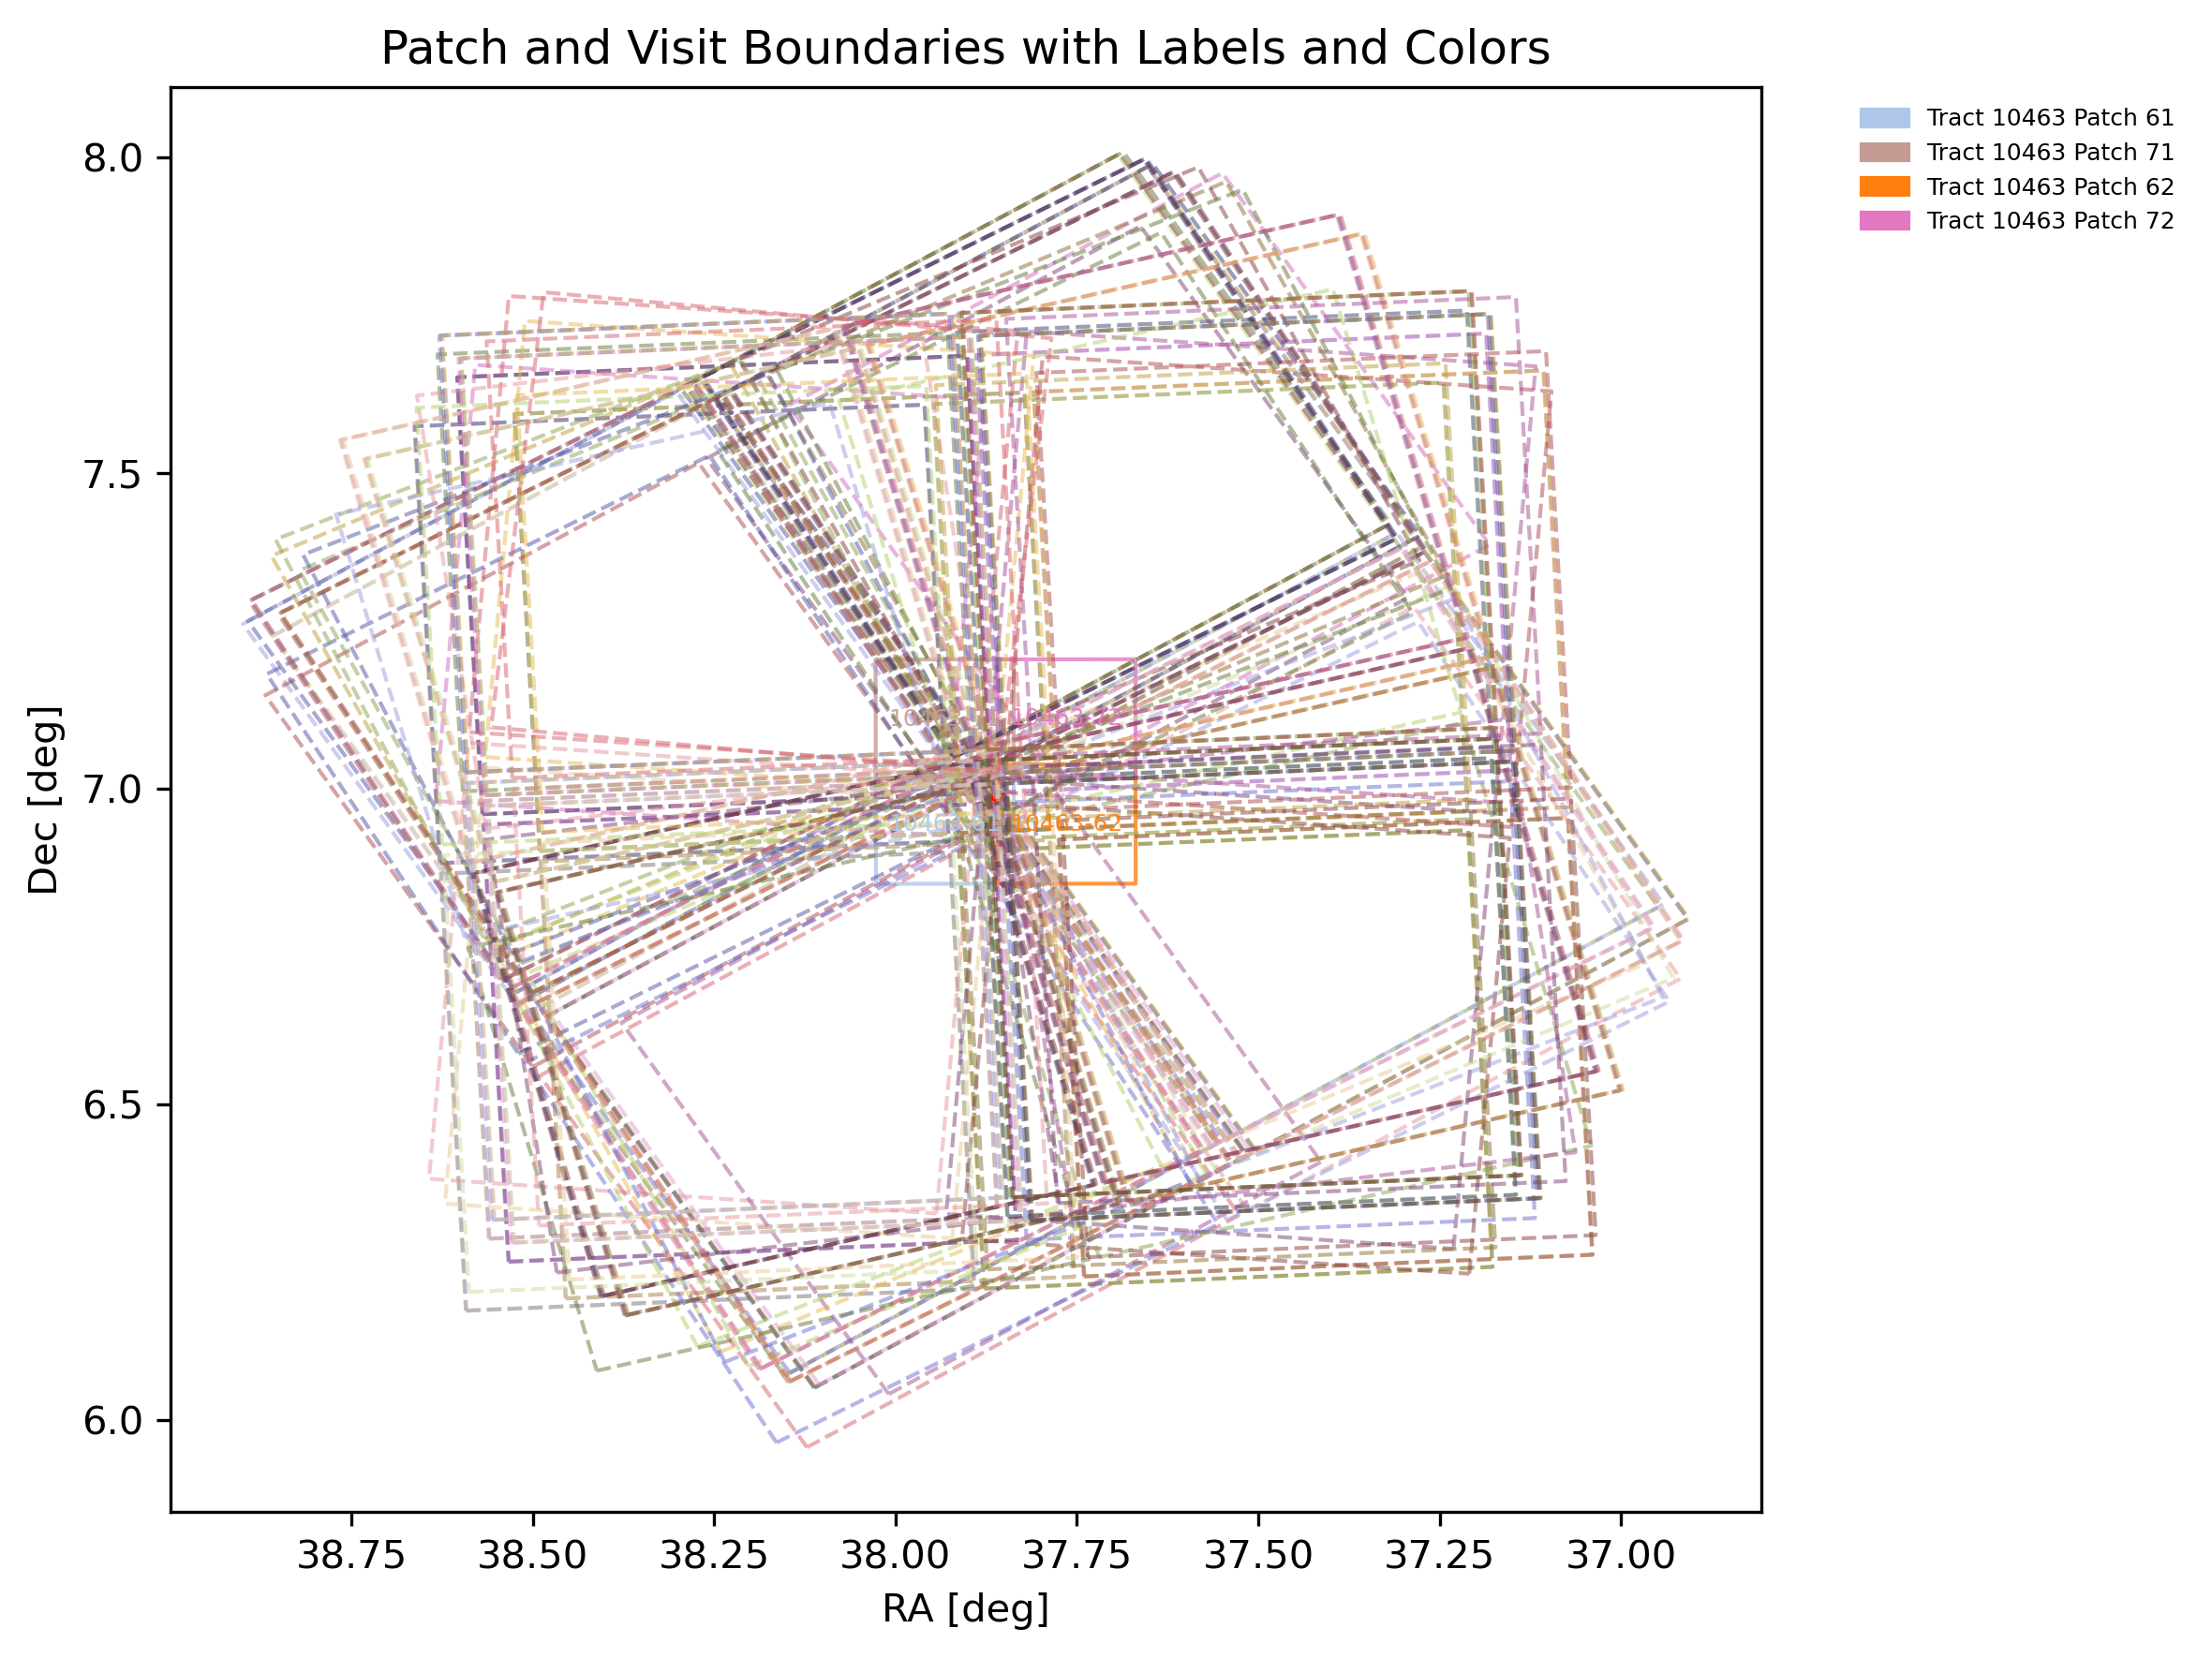

In [ ]:
# Collect visits that overlap with the tracts and patches in tpDict
visit_set = set()

for tract, patches in tpDict.items():
    for patch in patches:
        refs = butler.registry.queryDatasets(
            "calexp",
            tract=tract,
            patch=patch,  # pass list of patches
            collections=collection,
            skymap="lsst_cells_v1"
        )
        for ref in refs:
            visit_set.add(ref.dataId["visit"])

# Convert to sorted list
visits = sorted(visit_set)
print(f"Found {len(visits)} visits overlapping with patches in tpDict")

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(8, 6))
plotPatchAndVisitBoundaries(ax, tpDict, skymap, visits, detectors, butler, collection, instrument)

plt.tight_layout()
plt.show()

In [ ]:
for tract, patches in tpDict.items():
    for patch in patches:
        dataId = {"tract": tract, "patch": patch, "band": "i"}
        coadd = butler.get("deepCoadd_calexp", dataId, collections=collection, skymap="lsst_cells_v1")
        background = butler.get("deepCoadd_calexp_background", dataId, collections=collection, skymap="lsst_cells_v1")
        print(len(np.unique(background.getImage().array.flatten())))


1
1
1
1


In [80]:
# plt.imshow(np.log(coadd.getImage().array), cmap="gray", origin="lower")

#### Conclusion

To be deemed a success, the requirement for LSR-REQ-0093-V-07 and OSS-REQ-0387-V-05 states that the sky brightness determination shall have a precision of 1 percent.
In this notebook, we have extracted the flux at positions on the sky that are not associated with any detected objects and compared these values to the background model produced by the LSST Science Pipelines.

We find that the maximum error in the precision of the sky brightness determination is less than 1 percent in ~97% of samples taken on real ComCam data.
As such, **we conclude that the requirement has been met**.
